In [5]:
import sys
import os

from argparse import ArgumentParser

import torch
from pytorch_base.experiment import PyTorchExperiment
from pytorch_base.base_loss import BaseLoss

import random
from tqdm.auto import tqdm

from diffusers import UNet1DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

import numpy as np
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()


In [6]:
DATA_PATH = "/mydata/chip/luisb/mice_brain/" if torch.cuda.is_available() else "data"
integer_brain_coord = torch.tensor(np.load(f'{DATA_PATH}/integer_brain_coord.npy'))
reference_image = torch.tensor(np.load(f'{DATA_PATH}/reference_image.npy').astype(np.int16))
brain2_slices_rs = torch.tensor(np.load(f'{DATA_PATH}/brain2_slices_rs.npy'))
brain2_slices_rs, reference_image, integer_brain_coord

(tensor[1918708, 156] f64 n=299318448 (2.2Gb) x∈[-0.692, 12.450] μ=-7.468e-17 σ=1.000,
 tensor[528, 320, 456] i16 n=77045760 (0.1Gb) x∈[0, 516] μ=59.817 σ=78.802,
 tensor[1918708, 3] i64 n=5756124 (44Mb) x∈[9, 515] μ=237.173 σ=114.511)

In [7]:
# notmalize data
# normalize volume
means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))
means, stds

(tensor[157] x∈[-0.272, 109.213] μ=0.696 σ=8.744,
 tensor[157] x∈[0.084, 83.133] μ=0.788 σ=6.627)

In [8]:
reference_image = (reference_image - means[-1]) / stds[-1]
brain2_slices_rs = (brain2_slices_rs - means[:-1]) / stds[:-1]
brain2_slices_rs, reference_image

(tensor[1918708, 156] f64 n=299318448 (2.2Gb) x∈[-7.406, 97.790] μ=-0.307 σ=0.941,
 tensor[528, 320, 456] n=77045760 (0.3Gb) x∈[-1.314, 4.893] μ=-0.594 σ=0.948)

In [9]:
brain2_slices_rs[:, 145]

tensor[1918708] f64 15Mb x∈[-2.207, 10.855] μ=0.310 σ=1.029

# Dataset

In [10]:
import sys
import os

from argparse import ArgumentParser

import torch
from pytorch_base.experiment import PyTorchExperiment
from pytorch_base.base_loss import BaseLoss

import random
from tqdm.auto import tqdm

from diffusers import UNet1DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

import numpy as np
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()


In [11]:
def apply_circle_mask(img):
    W, H = img.shape[-2:]
    cp = torch.cartesian_prod(torch.arange(W, device=img.device), torch.arange(H, device=img.device))
    circle_mask = (cp[:, 0] - W / 2) ** 2 + (cp[:, 1] - W / 2) ** 2 <= (W / 2) ** 2
    return img * circle_mask.reshape(img.shape[-2:])

In [12]:
from mice.datasets.slice_dataset import SliceDataset
import lovely_tensors as lt
import os
lt.monkey_patch()


means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))


kwargs = {
    'path': f'{DATA_PATH}/sections',
    'im_size':64,
    'train_transform': True,
#     'rotation_angle': 30,
#     'rescale': 100,
    'stds':stds,
    'means':means
}

trainSet = SliceDataset(**kwargs)
print(trainSet[100])

tensor[2, 157, 64] n=20096 (78Kb) x∈[-2.759, 8.070] μ=0.251 σ=1.179


# Testing Diffussion model

In [13]:
from diffusers import UNet1DModel
from mice.training.conditional_training import load_model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')
model = UNet1DModel(
        sample_size=128,  # Adjusted to im_size
        in_channels=2,
        out_channels=1,
        layers_per_block=2,
        block_out_channels=(32, 64, 128, 256),
        down_block_types=(
            "DownBlock1D",
            "DownBlock1D",  # a regular ResNet downsampling block
            "AttnDownBlock1D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock1D",
        ),
        up_block_types=(
            "UpBlock1D",
            "AttnUpBlock1D",  # Keep the same
            "UpBlock1D",
            "UpBlock1D",  # Reduced the number of upsampling blocks accordingly
        ),
    ).to(device)
load_model(model, "checkpoints/ConditionalMiceBrain.pt")
model.eval()
""

models loaded from checkpoint checkpoints/ConditionalMiceBrain.pt


''

tensor[1, 128] x∈[-0.979, 3.280] μ=0.855 σ=0.707

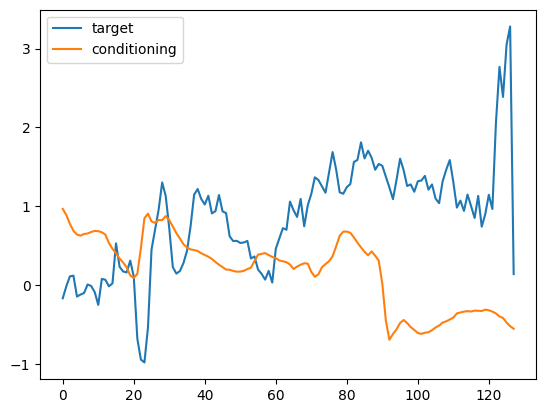

In [14]:
# load dataset
from mice.training.conditional_training import get_dataset
means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))
kwargs = {
    "path": f"{DATA_PATH}/sections",
    'im_size':128,
    "train_transform": True,
    'stds': stds,
    'means': means
}

trainSet, testSet = get_dataset(kwargs)
target_channel = 145
condition_channel = -1

target = testSet[0][:1, target_channel]
conditioning = testSet[0][:1, condition_channel]
plt.plot(target[0], label="target")
plt.plot(conditioning[0], label="conditioning")
plt.legend()  # Adds the legend to the plot
target

# Testing diffusion on one sample

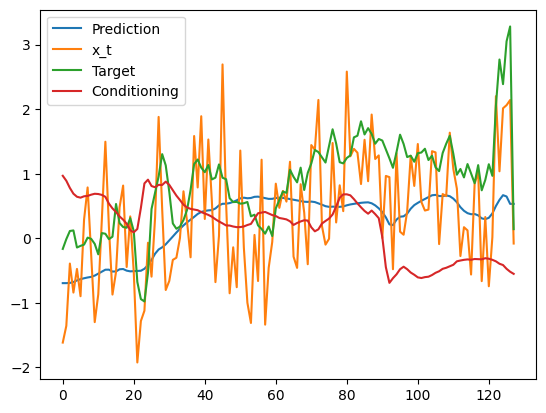

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([1, 1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor cuda:0 0.648

In [15]:
### from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler.config.clip_sample = True
noise_scheduler.config.clip_sample_range = 3.0

timesteps = torch.LongTensor([300]).to(device)

noise = torch.randn_like(target).to(device)
x_t = noise_scheduler.add_noise(target.to(device), noise, timesteps).to(device)


# we predict the noise for this step t
with torch.no_grad():
    input_ = torch.stack([x_t, conditioning.to(device)], dim=1)
    x_0_pred = model(input_, timestep=timesteps, return_dict=False)[0]
    
    # x_0_pred = noise_scheduler.step(
    #     noise_pred[0],
    #     timesteps,
    #     x_t
    # ).pred_original_sample
    # fading_factor = noise_scheduler.add_noise(torch.ones(1), torch.zeros(1), timesteps).to(device)
    # noise_factor = noise_scheduler.add_noise(torch.zeros(1), torch.ones(1), timesteps).to(device)
    # x_0_pred = (x_t.unsqueeze(1) - noise_factor[:, None, None] * noise_pred) / fading_factor[:, None, None]
    # x_0_pred = x_0_pred.clip(-3, 3)

plt.plot(x_0_pred.squeeze().cpu().detach(), label="Prediction")
plt.plot(x_t.squeeze().cpu().detach(), label="x_t")
plt.plot(target.squeeze().cpu().detach(), label="Target")
plt.plot(conditioning.squeeze().cpu().detach(), label="Conditioning")
plt.legend()  # Adds the legend to the plot
plt.show()
mse = torch.nn.MSELoss()
loss_recons = mse(x_0_pred, target.to(device))
# loss = mse(noise_pred, noise.to(device))
loss_recons

In [16]:
import torch.nn.functional as F
padded_reference = F.pad(reference_image, (0, 56, 0, 64, 0, 112))
padded_reference

tensor[640, 384, 512] n=125829120 (0.5Gb) x∈[-1.314, 4.893] μ=-0.364 σ=0.796

In [17]:
indices = torch.tensor([target_channel])
with torch.no_grad():
    volume = torch.zeros((*padded_reference.shape, len(indices)), dtype=torch.float32)
    volume[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2]] =  brain2_slices_rs[:, indices].clone().float()
volume

tensor[640, 384, 512, 1] n=125829120 (0.5Gb) x∈[-2.207, 10.855] μ=0.004 σ=0.127

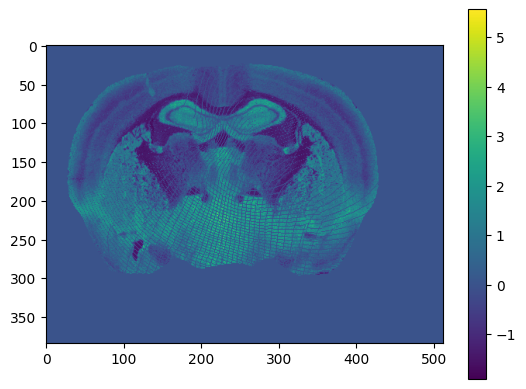

In [18]:
plt.imshow(volume[260])
plt.colorbar()

In [19]:
def flatten(permutation, volume, size=128):
    return volume.permute(permutation).flatten(0, 1).unfold(dimension=1, size=size, step=size).flatten(0, 1)

def unflatten(permutation, flat_volume, shape):
    size = flat_volume.shape[-1]
    permuted_shape = [shape[i] for i in permutation]
    inverse_permutation = [x.item() for x in torch.tensor(permutation).sort().indices]
    unfolded_volume = flat_volume.unflatten(0, (-1, permuted_shape[-2]//size)).transpose(-1, -2).flatten(-3, -2)
    return unfolded_volume.reshape(permuted_shape, 2).permute(inverse_permutation)

permutation = (0, 1, 2, 3)
unflatten(permutation,  flatten(permutation, volume), volume.shape) - volume

tensor[640, 384, 512, 1] n=125829120 (0.5Gb) all_zeros

In [58]:
import torch.nn as nn
class BrainSliceConditionalDiffusion(nn.Module):
    def __init__(self, image_shape, channels_indices, unet, buffer=5):
        super(BrainSliceConditionalDiffusion, self).__init__()
        self.unet = unet
        self.buffer = buffer
        self.channels = channels_indices

    def inpainting(self, pred_x_0, integer_brain_coord, brain2_slices_rs, reference_image):
        with torch.no_grad():
            pred_x_0[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2], :] *= 0
            pred_x_0[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2], :] +=  brain2_slices_rs[:, self.channels].clone().float() 
            # pred_x_0[:, :, :, -1] *= 0
            # pred_x_0[:, :, :, -1] += reference_image
        return pred_x_0

    def predict_x_0(self, t, x_t, noise_scheduler):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        timesteps = torch.LongTensor([t]).to(device)
        x_0_pred = self.unet(x_t.to(device), timesteps.to(device), return_dict=False)[0]
        return x_0_pred.cpu()

#     def step(self, t, target_t, x_t, noise_scheduler):
#         x_0_pred = self.predict_x_0(t, x_t, noise_scheduler)
#         new_timestep = torch.LongTensor([target_t]).to(device)
#         new_x_t = noise_scheduler.add_noise(x_0_pred, torch.randn_like(x_0_pred), new_timestep).to(device)

#         return new_x_t, noise_pred
    
    def step(
        self, i, t, iterator, pred_x_0,
        noise_scheduler, num_steps,
        integer_brain_coord, brain2_slices_rs, reference_image,
        batch_size, verbose=True, with_inpainting=True, 
    ):
            
        timestep = torch.LongTensor([t]).to(device)
        x_t = noise_scheduler.add_noise(pred_x_0, torch.randn_like(pred_x_0), timestep)

        permutations = [
            [0, 1, 2, 3],
            [1, 2, 0, 3],
            [2, 0, 1, 3]
        ]
        with torch.no_grad():
            permutation = permutations[i % len(permutations)]

            iterator.set_postfix({"state": f"rolling"})
            shifts = torch.randint(-16, 16, (3,))
            rolled = x_t.roll([x.item() for x in shifts], dims=[0, 1, 2])
            rolled_reference_image = reference_image.clone().roll([x.item() for x in shifts], dims=[0, 1, 2])

            axial_batches = flatten(permutation, rolled)
            axial_conditioning = flatten(permutation, rolled_reference_image.unsqueeze(-1))
            pred_x_0 = torch.zeros_like(axial_batches)
            assert(len(axial_batches) % batch_size == 0)

            unfolded_x_t = axial_batches.unfold(dimension=0, size=batch_size, step=batch_size).permute(0, 3, 1, 2)
            unfolded_conditioning = axial_conditioning.unfold(dimension=0, size=batch_size, step=batch_size).permute(0, 3, 1, 2)
            unfolded_input = torch.cat([unfolded_x_t, unfolded_conditioning], dim=2)
            for j, input in enumerate(unfolded_input):
                pred_x_0[j * batch_size: (j+1) * batch_size] = self.predict_x_0(t, input, noise_scheduler)
                iterator.set_postfix({"state": f"running batch {j}"})

            iterator.set_postfix({"state": f"starting making contiguous"})
            if not pred_x_0.is_contiguous():
                pred_x_0 = pred_x_0.contiguous()

            iterator.set_postfix({"state": f"starting unflattening"})
            pred_x_0 = unflatten(permutation, pred_x_0, x_t.shape)
            del axial_batches, axial_conditioning, unfolded_conditioning, unfolded_input, unfolded_x_t


            iterator.set_postfix({"state": f"unrolling"})
            pred_x_0 = pred_x_0.roll([-x.item() for x in shifts], dims=[0, 1, 2])
            if with_inpainting:
                pred_x_0 = self.inpainting(pred_x_0, integer_brain_coord, brain2_slices_rs, reference_image)
            return pred_x_0
    
    def diffusion_pipeline(
        self, x_0_start, t_start, t_end, noise_scheduler, batch_size, 
        integer_brain_coord, brain2_slices_rs, reference_image,
        num_steps=50, verbose=False
    ):
        with torch.no_grad():
            pred_x_0 = x_0_start.clone()
            
            timesteps = torch.linspace(t_start, t_end, num_steps + 1).int()
            iterator = tqdm(range(1, len(timesteps)), disable=not verbose)
            for i in iterator:
                t = timesteps[i - 1]

                pred_x_0 = self.step(
                    i, t, iterator, pred_x_0,
                    noise_scheduler, num_steps,
                    integer_brain_coord, brain2_slices_rs, reference_image,
                    batch_size, verbose, with_inpainting=False
                )
            return pred_x_0
        
    def guided_diffusion_pipeline(
        self, x_0_start, t_start, t_end, noise_scheduler, num_steps,
        integer_brain_coord, brain2_slices_rs, reference_image,
        batch_size, verbose=True, with_inpainting=True
    ):
        pred_x_0 = x_0_start.clone()

        timesteps = torch.linspace(t_start, t_end + self.buffer, num_steps + 1).int()
        iterator = tqdm(range(1, len(timesteps)))
        for i in iterator:
            t = timesteps[i - 1]
            pred_x_0 = self.step(
                i, t, iterator, pred_x_0,
                noise_scheduler, num_steps,
                integer_brain_coord, brain2_slices_rs, reference_image,
                batch_size, verbose, with_inpainting
            )

        pred_x_0 = self.diffusion_pipeline(
            pred_x_0, t_end + self.buffer, t_end,
            noise_scheduler, batch_size, 
            integer_brain_coord, brain2_slices_rs, reference_image,
            num_steps=self.buffer, verbose=verbose
        )

        return pred_x_0


In [59]:
from tqdm.auto import tqdm
bsd = BrainSliceConditionalDiffusion(volume.shape, channels_indices=indices, unet=model, buffer=5)

res = bsd.guided_diffusion_pipeline(
    x_0_start = volume, t_start=999, t_end=0, noise_scheduler=noise_scheduler, num_steps=50,
    integer_brain_coord=integer_brain_coord, brain2_slices_rs=brain2_slices_rs, reference_image=padded_reference,
    batch_size=2*30720, verbose = True, with_inpainting=True
)

100% 50/50 [17:18<00:00, 20.77s/it, state=unrolling]                 
100% 5/5 [01:39<00:00, 19.92s/it, state=unrolling]                 


In [61]:
np.save(f"mice_recons_{target_channel}", res.cpu().detach().numpy())

In [ ]:
res

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# slices 260, 300, 191, 175, 450, 458
slice_idx = 450
channel = 0
# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

# Display images in subplots
slice1 = res[:, :, :, channel][slice_idx].cpu()
slice2 = volume[:, :, :][slice_idx].cpu()
a = torch.min(torch.max(slice1), torch.max(slice2))
b = torch.max(torch.min(slice1), torch.min(slice2))
im1 = ax1.imshow(slice1, vmin = b.item(), vmax=a.item())
im2 = ax2.imshow(slice2, vmin = b.item(), vmax=a.item())

# Add smaller colorbars to each subplot
for ax, im in zip([ax1, ax2], [im1, im2]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust 'size' and 'pad' for custom sizing
    fig.colorbar(im, cax=cax)


In [ ]:
plt.imshow(res[:, :, :, -1][458].cpu())